In [338]:
import numpy as np
from brainspace.plotting import plot_hemispheres
import nibabel as nib
from brainspace.mesh.mesh_io import read_surface
import pandas as pd
from surfplot import Plot
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [276]:
canonical_midthick_path = 'tpl-avg_space-canonical_den-0p5mm_midthickness.surf.gii'
canonical_midthick = read_surface(canonical_midthick_path)

sub_data = '/home/myousif/graham/scratch/AV100v4_2018_03_12_Roy_Haast.csv'

features = ['thickness','curvature','gyrification','surfarea']
hipp_feature_path = '/home/myousif/graham/scratch/DM2_hippunfold_v1.0.0_run1/hippunfold/sub-{sub}/surf/sub-{sub}_space-T1w_den-0p5mm_label-hipp_{feature}.dscalar.nii'

surfarea_feature_path = '/home/myousif/graham/scratch/DM2_hippunfold_v1.0.0_run1/hippunfold/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-hipp_{feature}.shape.gii'

flatmap_path = '/home/myousif/graham/scratch/DM2_hippunfold_v1.0.0_run1/hippunfold/sub-S01/surf/sub-S01_hemi-R_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii'
flatmap = read_surface(flatmap_path)

In [133]:
subjects = [sub.split('/')[-2].replace('sub-','') for sub in glob('/home/myousif/graham/scratch/DM2_hippunfold_v1.0.0_run1/hippunfold/sub-*/')]
sub_df = pd.read_csv(sub_data,index_col=0)
sub_df.STUDY_ID = [sub.replace('S0','S') for sub in sub_df.STUDY_ID]
sub_df = sub_df[sub_df.STUDY_ID.isin(subjects)]

In [222]:
hippdata = lambda sub,feature: nib.load(hipp_feature_path.format(sub=sub,feature=feature)).get_fdata()
hippdata_path = lambda path, sub, feature,hemi: nib.load(path.format(sub=sub,feature=feature,hemi=hemi)).darrays[0].data

In [218]:
def load_dataset_feature(subjects,feature):
    sub1_data = hippdata(subjects[0],feature)
    data_feature = np.zeros((np.size(subjects),np.size(sub1_data)))
    data_feature[0,:] = sub1_data
    for idx,sub in enumerate(subjects[1:]):
        data_feature[idx+1,:] = hippdata(sub=sub, feature=feature)
    return data_feature
        
    

In [219]:
thick = load_dataset_feature(sub_df.STUDY_ID,'thickness')
curv = load_dataset_feature(sub_df.STUDY_ID,'curvature')
gyr = load_dataset_feature(sub_df.STUDY_ID,'gyrification')



In [436]:
np.savez('dm2_hippo_feature_data.npz',thick=thick,curv=curv,gyr=gyr,surfarea=surfarea)

In [229]:
def load_dataset_path_feature(path,subjects,feature,hemi=['L','R']):
    if len(hemi)>1:
        data ={'L':None,'R':None}
        
        for h in hemi:
            sub1_data = hippdata_path(path,subjects[0],feature,hemi=h)
            data_feature = np.zeros((np.size(subjects),np.size(sub1_data)))
            data_feature[0,:] = sub1_data

            for idx,sub in enumerate(subjects[1:]):
                data_feature[idx+1,:] = hippdata_path(path,sub=sub, feature=feature,hemi=h)
            
            data[h] = data_feature
        
        return np.concatenate((data['L'], data['R']),axis=1)
    
    else:
        sub1_data = hippdata_path(path,subjects[0],feature,hemi=h)
        data_feature = np.zeros((np.size(subjects),np.size(sub1_data)))
        data_feature[0,:] = sub1_data

        for idx,sub in enumerate(subjects[1:]):
            data_feature[idx+1,:] = hippdata_path(path,sub=sub, feature=feature)
    
        return data_feature

In [230]:
surfarea = load_dataset_path_feature(surfarea_feature_path, sub_df.STUDY_ID,'surfarea',hemi=['L','R'])

In [369]:
lr_split =  lambda feature: np.split(feature,2,axis=feature.shape.index(np.max(np.shape(feature))))

In [169]:
def limit_range(feature,n_std=3,allow_negative = False):
    mean = feature.mean() 
    std = feature.std()
    
    upper = mean + n_std*std
    lower = mean - n_std*std
    
    
    if lower <=0 and allow_negative == False:
        lower = 0
    else:
        feature[feature < lower] = lower
            
    feature[feature > upper] = upper
    
    
    return feature

In [370]:
def plot_hippo(feature,n_std=0,allow_negative=False):
    feature_split = lr_split(feature)
    p = Plot(surf_lh=canonical_midthick,surf_rh=canonical_midthick,views=['dorsal','ventral'],zoom=1)
    p.add_layer({'left':limit_range(feature_split[0],n_std,allow_negative),'right':limit_range(feature_split[1],n_std,allow_negative)},cmap='viridis')
    fig = p.build()
    return p, fig

In [379]:
def plot_flatmap(feature,hemi='both',n_std=0,allow_negative=False):
    if hemi == 'both':
        feature_split = lr_split(feature)
        p = Plot(surf_lh=flatmap,surf_rh=flatmap,views=['dorsal'],zoom = 1.1)
        p.add_layer({'left':limit_range(feature_split[0],n_std,allow_negative),'right':limit_range(feature_split[1],n_std,allow_negative)},cmap='viridis')
        fig = p.build()
    else:
        p = Plot(surf_lh=flatmap,views=['dorsal'],zoom = 1.1)
        p.add_layer({'left':limit_range(feature,n_std,allow_negative)},cmap='viridis')
        fig = p.build()
    return p, fig

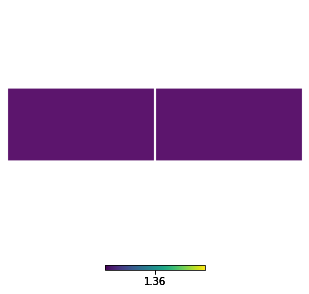

In [291]:
p_test, fig_test = plot_flatmap(thick_s01,3)

(<surfplot.plotting.Plot at 0x7f11e0aafca0>, <Figure size 432x360 with 2 Axes>)

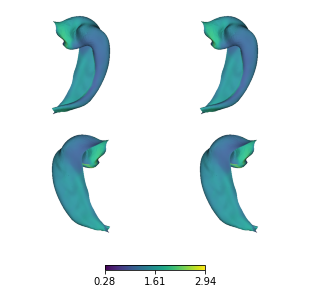

In [294]:
plot_hippo(np.mean(thick,axis=0),4)

(<surfplot.plotting.Plot at 0x7f11c3797b20>, <Figure size 432x360 with 2 Axes>)

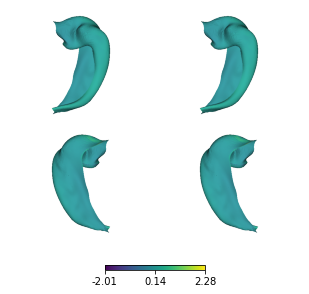

In [274]:
plot_hippo(np.mean(curv,axis=0),3, allow_negative=True)

(<surfplot.plotting.Plot at 0x7f121fad2640>, <Figure size 432x360 with 2 Axes>)

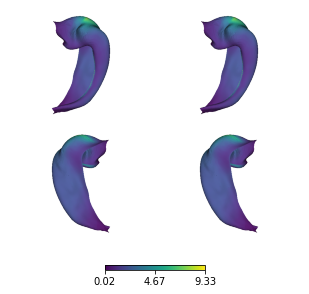

In [176]:
plot_hippo(np.mean(gyr,axis=0),4)

In [201]:
clinical_features = ['Glucose_t0_FP','HbA1c_mol','Tot_chol','HDL','LDL','Triglyc','HEMAT','BMI','OSBP','ODBP'] 
cog_features =['MEMORY','EXECUTIVE_ATTENTION','PROCESSING_SPEED','OVERALL_COGNITION']

In [186]:
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM


In [296]:
def slm_reduced(model, explanitory_variable):
    
    slm = SLM(
        model,
        explanitory_variable,
        surf=flatmap,
        correction=['fdr','rft'],
        cluster_threshold=0.01,
    )
    
    return slm

In [430]:
sex_bool = sub_df.SEX == 'male'
sex_bool = sex_bool.astype('int')
na2mean = lambda series: series.fillna(series.mean())

hbca1c_nafill = sub_df.HbA1c_mol.fillna(sub_df.HbA1c_mol.mean())
memory_nafill = na2mean(sub_df.MEMORY)

term_age = FixedEffect(sub_df.N_AGE)
term_sex = FixedEffect(sub_df.SEX.astype('category'))
term_glu = FixedEffect(sub_df.Glucose_t0_FP)
term_hba1c = FixedEffect(hbca1c_nafill)
term_tot_chol = FixedEffect(sub_df.Tot_chol)
term_triglyc = FixedEffect(sub_df.Triglyc)

term_memory = FixedEffect(memory_nafill)

In [431]:
model_fixed = term_age + term_sex
model_glu = model_fixed + term_glu
model_hba1c = model_fixed + term_hba1c
model_tot_chol = model_fixed + term_tot_chol
model_triglyc =  model_fixed + term_triglyc

model_memory = model_fixed + term_memory

In [434]:
model_glu

,intercept,N_AGE,SEX_female,SEX_male,Glucose_t0_FP
0,1,56.0,0,1,4.8
1,1,58.0,1,0,4.9
2,1,66.0,1,0,5.3
3,1,60.0,0,1,5.5
4,1,64.0,1,0,5.2
...,...,...,...,...,...
126,1,65.0,0,1,7.9
127,1,56.0,1,0,6.5
128,1,56.0,1,0,6.5
129,1,52.0,0,1,5.4


In [433]:
slm_glu_thick = slm_reduced(model_glu, sub_df.Glucose_t0_FP)
slm_glu_thick.fit(thick)

In [420]:
slm_glu_area = slm_reduced(model_glu, sub_df.Glucose_t0_FP)
slm_glu_area.fit(surfarea)

(<surfplot.plotting.Plot at 0x7f1309ddd5b0>, <Figure size 432x360 with 2 Axes>)

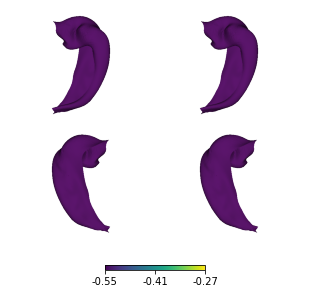

In [421]:
plot_hippo(slm_glu_thick.t,allow_negative=True)

(<surfplot.plotting.Plot at 0x7f1309de6220>, <Figure size 432x360 with 2 Axes>)

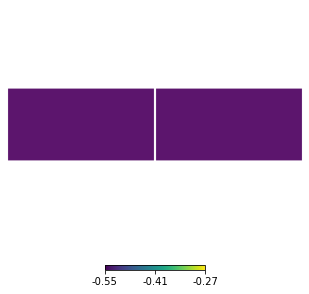

In [422]:
plot_flatmap(slm_glu_thick.t,allow_negative=True)

(<surfplot.plotting.Plot at 0x7f130d238d90>, <Figure size 432x360 with 2 Axes>)

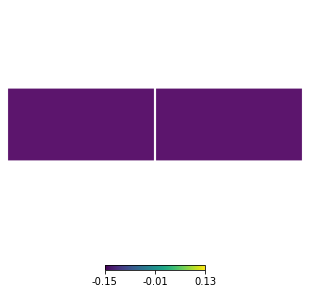

In [398]:
plot_flatmap(slm_glu_area.t,allow_negative=True)

<AxesSubplot:>

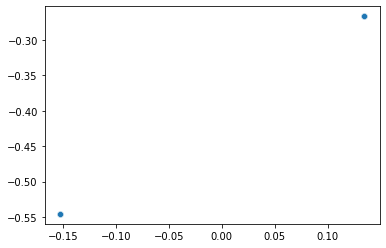

In [406]:
sns.scatterplot(x = slm_glu_area.t.flatten() , y = slm_glu_thick.t.flatten())

<AxesSubplot:ylabel='Count'>

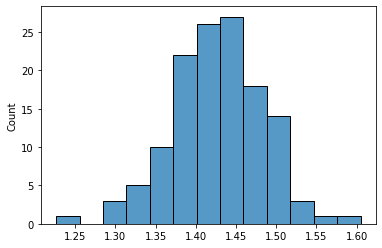

In [310]:
sns.histplot(thick.mean(axis=1))

<AxesSubplot:ylabel='Count'>

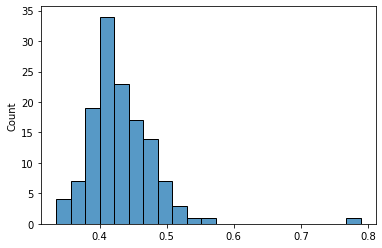

In [309]:
sns.histplot(thick.std(axis=1))

<AxesSubplot:ylabel='Count'>

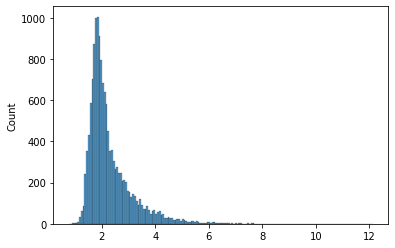

In [311]:
sns.histplot(thick.max(axis=0))

<AxesSubplot:ylabel='Count'>

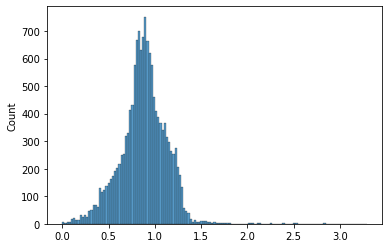

In [312]:
sns.histplot(thick.min(axis=0))

<AxesSubplot:xlabel='Glucose_t0', ylabel='Count'>

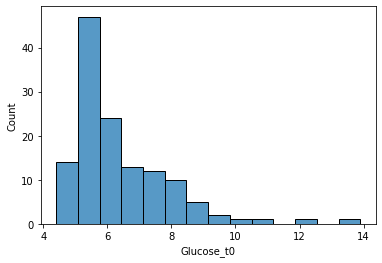

In [322]:
sns.histplot(sub_df.Glucose_t0)

<AxesSubplot:xlabel='HbA1c_mol', ylabel='Count'>

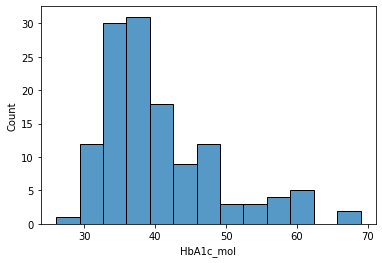

In [321]:
sns.histplot(sub_df.HbA1c_mol)

In [ ]:
slm_glu.t

In [ ]:
slm_glu.t

In [332]:
slm_hba1c = slm_reduced(model_hba1c, hbca1c_nafill)
slm_hba1c.fit(thick)

(<surfplot.plotting.Plot at 0x7f11604c3520>, <Figure size 432x360 with 2 Axes>)

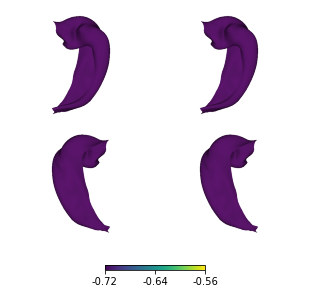

In [334]:
plot_hippo(slm_hba1c.t,allow_negative=True)

(<surfplot.plotting.Plot at 0x7f130e7d09a0>, <Figure size 432x360 with 2 Axes>)

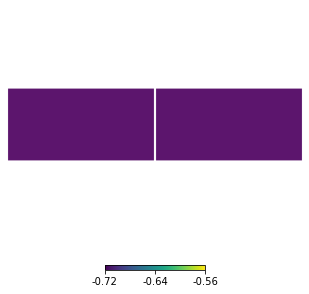

In [352]:
plot_flatmap(slm_hba1c.t,allow_negative=True)

In [382]:
slm_memory = slm_reduced(model_memory, memory_nafill)
slm_memory.fit(thick)


(<surfplot.plotting.Plot at 0x7f130def51f0>, <Figure size 432x360 with 2 Axes>)

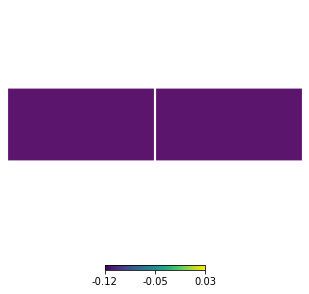

In [384]:
plot_flatmap(slm_memory.t,allow_negative=True)

(<surfplot.plotting.Plot at 0x7f130d9891f0>, <Figure size 432x360 with 2 Axes>)

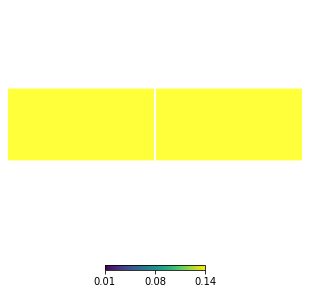

In [408]:
slm_glu.fit(curv)
plot_flatmap(slm_glu.t,allow_negative=True)

In [409]:
slm_glu.t

array([[0.00989657, 0.00989657, 0.00989657, ..., 0.14349138, 0.14349138,
        0.14349138]])

In [425]:
term_sex

,intercept,SEX_0,SEX_1
0,1,0,1
1,1,1,0
2,1,1,0
3,1,0,1
4,1,1,0
...,...,...,...
126,1,0,1
127,1,1,0
128,1,1,0
129,1,0,1
